In [1]:
import os
import numpy as np
import re

import sys
sys.path.insert(0, '..')
import metrics.charades_classify as cc

import matplotlib.pyplot as plt
from inspect import signature

from scipy import signal
from torch.nn import MaxPool1d

import torch

In [2]:
# gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_clip_test.txt'
gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_allFrames_test.txt'
cls_file = '/data/OnlineActionRecognition/outputs/causal_eval_charades_r50_i3d_nl_32x2/causal_eval_charades_r50_i3d_nl_32x2_4gpus_full_clip_joined.txt'
per_frame = True
calibrated = False

In [3]:
def map_func(submission_array, gt_array, w_array):
    m_aps = []
    a_prec = np.zeros(submission_array.shape)
    a_recall = np.zeros(submission_array.shape)
    n_classes = submission_array.shape[1]
    for oc_i in range(n_classes):
        sorted_idxs = np.argsort(-submission_array[:, oc_i])
        sorted_gt = gt_array[:, oc_i][sorted_idxs]
        tp = sorted_gt == 1
        fp = np.invert(tp)
        n_pos = tp.sum()
        n_gt = sorted_gt.sum()

        t_pcs = np.cumsum(tp)
        f_pcs = np.cumsum(fp)

        w_t_pcs = t_pcs * w_array[oc_i]
        prec = w_t_pcs / (f_pcs + w_t_pcs).astype(float)
        recall = t_pcs / n_gt.astype(float)
        avg_prec = 0
        for i in range(submission_array.shape[0]):
            if tp[i]:
                avg_prec += prec[i]
        m_aps.append(avg_prec / n_pos.astype(float))
        a_prec[:, oc_i] = prec
        a_recall[:, oc_i] = recall
    m_aps = np.array(m_aps)
    m_ap = np.nanmean(m_aps)
    w_ap = np.nansum(m_aps * gt_array.sum(axis=0) / gt_array.sum().astype(float))
         
    return m_ap, w_ap, m_aps, a_prec, a_recall

def charades_map(submission_array, gt_array, w_array=None):    
    fix = submission_array.copy()
    empty = np.sum(gt_array, axis=1) == 0
    fix[empty, :] = np.NINF
    if w_array is None:
        w_array = np.ones(submission_array.shape[1])

    return map_func(fix, gt_array, w_array) 

def plot_pr_curve(p, r, a):
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, alpha=0.2, color='b', **step_kwargs)
    
    plt.axhline(a)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(a))
    plt.show()

In [4]:
def divide_per_clip(ids, classes):
    clips_ids = []
    clips_classes = []

    video_name = None
    for i, video_frame in enumerate(ids):
        name = video_frame.split('_')[0]
        if name != video_name:
            # new video! But first, save old video
            if i > 0:
                clips_ids.append(np.array(video_ids))
                clips_classes.append(np.array(video_classes))
            # star new one
            video_ids = []
            video_classes = []
            video_name = name
            
        video_ids.append(video_frame)
        video_classes.append(classes[i])
        
    # Append last video
    clips_ids.append(np.array(video_ids))
    clips_classes.append(np.array(video_classes))
        
    return np.array(clips_ids), np.array(clips_classes)

In [5]:
gt_ids, gt_classes = cc.read_file(gt_path) # if per_frame else cc.load_charades(gt_path)
gt_classes = np.array(gt_classes)

w_array = cc.get_w_array(gt_classes) if calibrated else None
n_test = len(gt_ids)

# Load test scores
test_ids, test_scores = cc.read_file(cls_file)

# Check if there are duplicate items
test_ids, test_index_order = np.unique(test_ids, return_index=True)
test_scores = np.array(test_scores)[test_index_order]

# Dividing per clip
gt_clips_ids, gt_clips_classes = divide_per_clip(gt_ids, gt_classes)
test_clips_ids, test_clips_classes = divide_per_clip(test_ids, test_scores)

In [6]:
def video_output(outputs):
    num_clips, num_classes = outputs.shape
    max_pool = MaxPool1d(num_clips)
    
    outputs = torch.tensor(outputs)

    data = outputs.view(1, -1, num_classes).contiguous()
    data = data.permute(0, 2, 1).contiguous()

    data = max_pool(data)
    video_data = data.view(num_classes).contiguous()

    return video_data

def select_ten_clips(video_ids, video_classes):
    expanded_sample_length = int(video_ids[0].split('_')[1])
    num_frames = int(video_ids[-1].split('_')[1])
    
    sample_start_pos = np.linspace(expanded_sample_length, num_frames, 10, dtype=int)
    ids = sample_start_pos - expanded_sample_length
    
    return video_ids[ids], video_classes[ids]

In [7]:
def get_perF_result(method='mean'):
    test_clips_classes_perF = []
    gt_clips_classes_perF = []
    num_classes = gt_clips_classes[0].shape[1]

    for v in range(gt_clips_ids.shape[0]):
        v_gt_ids = gt_clips_ids[v]
        v_gt_targets = gt_clips_classes[v]
        v_test_ids = test_clips_ids[v]
        v_test_targets = test_clips_classes[v]

        new_test_targets = []
        new_gt_targets = []

        clip_length = int(re.match('(.*)_(\d*)', v_test_ids[0]).groups()[-1]) +1 # in number of frames
        num_frames = len(v_gt_ids)

        norm_weights = signal.gaussian(clip_length, std=clip_length/2)

        for f_id in range(num_frames):
            first_clip = max(f_id - clip_length + 1, 0)
            last_clip = f_id + 1
            clips_targets = v_test_targets[first_clip:last_clip]
            
            if method == 'gaussian':
                norm = norm_weights[:clips_targets.shape[0]]
                clips_targets = np.swapaxes(clips_targets, 0, 1)
                new_test_targets.append(np.average(clips_targets, axis=1, weights=norm))
                
            elif method == 'mean':
                new_test_targets.append(np.mean(clips_targets, axis=0))
                
            elif method == 'last_frame':
                clip_id = f_id - clip_length + 1
                if clip_id >= 0:
                    new_test_targets.append(v_test_targets[clip_id])
                    new_gt_targets.append(v_gt_targets[clip_id])

        test_clips_classes_perF.append(new_test_targets)
        gt_clips_classes_perF.append(new_gt_targets)
        
    if method in ['gaussian', 'mean']:
        gt_clips_classes_perF = np.vstack(gt_clips_classes)

    return np.array(test_clips_classes_perF), np.array(gt_clips_classes_perF)

In [8]:
# def get_results_per_clip(delay=3.0):

#     test_clips_classes_perC_mean = []
#     gt_clip_classes = []

#     for vid, v in enumerate(test_clips_classes_perF_mean):
#         num_frames = v.shape[0]
#         max_pool = MaxPool1d(num_frames)

#         v_tensor = torch.tensor(v).permute(1, 0)
#         v_tensor = v_tensor.view(-1, v_tensor.shape[0], v_tensor.shape[1])
#         pred = max_pool(v_tensor).view(-1)
#         test_clips_classes_perC_mean.append(pred.numpy())

#         gt_clip = (np.sum(gt_clips_classes[vid], axis=0) > 0).astype(int)
#         gt_clip_classes.append(gt_clip)

In [9]:
# per frame result using last frame as gt

test_perF_clip_scores, gt_perF_clip_scores = get_perF_result('last_frame')
test_perF_scores = np.vstack(test_perF_clip_scores)
gt_perF_scores = np.vstack(gt_perF_clip_scores)

mAP_f, wAP_f, ap_f, prec_f, recall_f = charades_map(test_perF_scores, gt_perF_scores, w_array)

print(mAP_f, wAP_f)

thr_f = np.zeros(157)
for c in range(157):
    idx = np.where(prec_f[:, c] > ap_f[c])[0][-1]
    thr_f[c] = test_scores[idx, c]

0.17818482219315127 0.2835159504095477


In [10]:
# per clip result using the 10 clip 

test_classes_10 = [select_ten_clips(clip_id, clip_data)[1] for clip_id, clip_data in zip(test_clips_ids, test_clips_classes)]

test_clip_10 = np.array([video_output(t_c).numpy() for t_c in test_classes_10])
gt_clips_10 = np.array([(sum(gt_c) > 0).astype(int) for gt_c in gt_clips_classes])

mAP_10, wAP_10, ap_10, prec_10, recall_10 = charades_map(test_clip_10, gt_clips_10, w_array)

print(mAP_10, wAP_10)

thr_10 = np.zeros(157)
for c in range(157):
    idx = np.where(prec_10[:, c] > ap_10[c])[0][-1]
    thr_10[c] = test_scores[idx, c]

0.31687666392552655 0.4134873028104368


In [10]:
# per frame using mean of all clips that have the frame
test_clips_classes_perF_mean, gt_targets_perF = get_perF_result('mean')

test_targets_perF_mean = np.vstack(test_clips_classes_perF_mean)

mAP_fm, wAP_fm, ap_fm, prec_fm, recall_fm = charades_map(test_targets_perF_mean, gt_targets_perF, w_array)

print(mAP_fm, wAP_fm)

thr_fm = np.zeros(157)
for c in range(157):
    idx = np.where(prec_fm[:, c] > ap_fm[c])[0][-1]
    thr_fm[c] = test_targets_perF_mean[idx, c]

0.19684926497965574 0.3066824436878236


In [11]:
# per frame gaussian
test_targets_perF_gauss, gt_targets_perF = get_perF_result('gaussian')
test_perF_gauss_scores = np.vstack(test_targets_perF_gauss)

mAP_fg, wAP_fg, ap_fg, prec_fg, recall_fg = charades_map(test_perF_gauss_scores, gt_targets_perF, w_array)

print(mAP_fg, wAP_fg)

thr_fg = np.zeros(157)
for c in range(157):
    idx = np.where(prec_fg[:, c] > ap_fg[c])[0][-1]
    thr_fg[c] = test_perF_gauss_scores[idx, c]

0.1962737190665863 0.3059261642551862


In [13]:
# per clip 10 but using per frame mean results

test_classes_10_perF_mean = [select_ten_clips(np.array(clip_id), np.array(clip_data))[1] for clip_id, clip_data in zip(gt_clips_ids, test_clips_classes_perF_mean)]
test_clip_10_perF_mean = np.array([video_output(t_c).numpy() for t_c in test_classes_10_perF_mean])

gt_clips_10 = np.array([(sum(gt_c) > 0).astype(int) for gt_c in gt_clips_classes])

mAP_10m, wAP_10m, ap_10m, prec_10m, recall_10m = charades_map(test_clip_10_perF_mean, gt_clips_10, w_array)

print(mAP_10m, wAP_10m)

thr_10m = np.zeros(157)
for c in range(157):
    idx = np.where(prec_10m[:, c] > ap_10m[c])[0][-1]
    thr_10m[c] = test_targets_perF_mean[idx, c]

0.322216626511807 0.4192401305609189


In [14]:
# per clip but using all per frame mean results

test_clip_clip_perF_mean = np.array([video_output(np.array(t_c)).numpy() for t_c in test_clips_classes_perF_mean])

mAP_cm, wAP_cm, ap_cm, prec_cm, recall_cm = charades_map(test_clip_clip_perF_mean, gt_clips_10, w_array)

print(mAP_cm, wAP_cm)

thr_cm = np.zeros(157)
for c in range(157):
    idx = np.where(prec_10m[:, c] > ap_cm[c])[0][-1]
    thr_cm[c] = test_targets_perF_mean[idx, c]

0.3254864343549057 0.42266772701602107


In [ ]:
## stop ##

In [35]:
prec_f.shape, recall_f.shape, prec.shape, recall.shape

((1153408, 157), (1153408, 157), (1863, 157), (1863, 157))

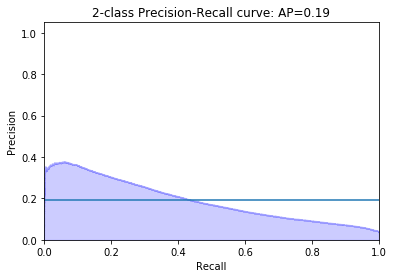

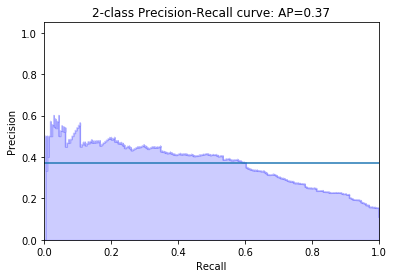

In [39]:
c = 6
plot_pr_curve(prec_f[:, c], recall_f[:, c], ap_f[c])
plot_pr_curve(prec[:, c], recall[:, c], ap[c])

In [65]:
np.sum((ap > 0.2).astype(int))

57

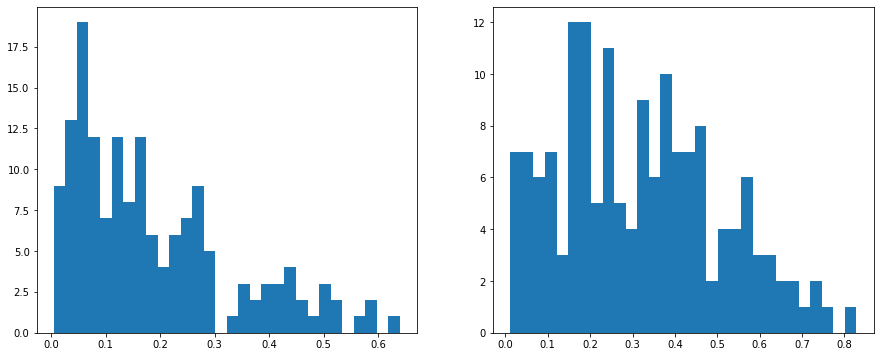

In [42]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(ap_f, bins=30)
ax2.hist(ap, bins=30)
plt.show()

In [49]:
for i, ap_i in enumerate(ap):
    print('{}: {:.02%} | {:.02%}'.format(i, ap_f[i], ap_i))

0: 27.35% | 44.35%
1: 28.29% | 50.34%
2: 27.73% | 45.39%
3: 16.21% | 30.98%
4: 18.83% | 29.45%
5: 17.26% | 27.86%
6: 19.01% | 37.31%
7: 2.52% | 4.69%
8: 27.29% | 56.94%
9: 16.69% | 39.54%
10: 5.17% | 8.86%
11: 58.50% | 73.26%
12: 28.72% | 40.30%
13: 7.97% | 17.50%
14: 37.04% | 45.49%
15: 42.81% | 57.30%
16: 41.58% | 59.01%
17: 2.92% | 11.06%
18: 7.19% | 19.52%
19: 21.71% | 23.74%
20: 32.37% | 47.15%
21: 26.11% | 46.83%
22: 6.20% | 17.52%
23: 5.62% | 14.79%
24: 0.88% | 2.81%
25: 12.46% | 35.99%
26: 49.57% | 62.62%
27: 16.99% | 43.41%
28: 8.36% | 19.87%
29: 11.67% | 24.28%
30: 8.27% | 27.58%
31: 0.76% | 2.08%
32: 46.21% | 62.34%
33: 20.17% | 32.32%
34: 10.24% | 20.03%
35: 9.47% | 19.54%
36: 3.08% | 8.46%
37: 15.24% | 17.41%
38: 19.97% | 26.48%
39: 6.80% | 20.27%
40: 20.44% | 37.12%
41: 11.10% | 24.18%
42: 6.40% | 19.67%
43: 11.98% | 31.31%
44: 6.36% | 11.11%
45: 0.57% | 1.17%
46: 5.60% | 18.05%
47: 38.73% | 56.34%
48: 5.09% | 14.43%
49: 12.29% | 31.56%
50: 3.73% | 14.87%
51: 49.27% | 57.

In [50]:
thr

array([3.6470163e-01, 2.1831100e-02, 1.9492227e-01, 2.6262040e-02,
       1.7548070e-02, 6.3316600e-03, 1.7698514e-01, 2.2943200e-03,
       8.7456960e-02, 1.3753570e-02, 2.4659400e-03, 2.4193728e-01,
       6.5618100e-03, 1.7279700e-03, 8.8722400e-03, 8.6667591e-01,
       3.7503680e-02, 1.1408080e-02, 5.4169500e-03, 2.6095780e-02,
       6.1299660e-02, 2.7542210e-02, 1.9179850e-02, 1.6435410e-02,
       1.2528000e-04, 4.3863700e-03, 4.5868840e-02, 4.6966140e-02,
       1.4444180e-02, 3.5462500e-03, 6.7200900e-03, 6.6921400e-03,
       2.9224566e-01, 3.3614913e-01, 1.7552890e-01, 1.9834980e-02,
       8.7973900e-03, 1.6257450e-02, 7.2726200e-03, 5.6685400e-03,
       8.9810400e-03, 4.4199800e-03, 3.3569870e-02, 9.5207400e-03,
       2.0389620e-02, 5.6673500e-03, 3.2226900e-03, 1.9511390e-02,
       5.9008700e-03, 7.7297800e-03, 9.1738300e-03, 2.5849600e-02,
       1.6472150e-02, 4.5023570e-02, 2.3403310e-02, 5.6547600e-03,
       5.6782300e-03, 5.7030520e-02, 1.9554280e-02, 7.0952058e